In [2]:
!pip install rdkit-pypi numpy Pillow pandas seaborn matplotlib tqdm

import sys
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

In [3]:
generated_df = pd.read_csv("generated_molecules.csv")
enumerated_df = pd.read_csv("enumerated_smiles.csv")



generated_smiles = generated_df['SMILES'].head(15).tolist()
enumerated_smiles = enumerated_df['Enumerated_SMILES'].head(15).tolist()

# Convert SMILES to molecules
generated_mols = []
enumerated_mols = []


for smiles in generated_smiles:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        generated_mols.append(mol)

for smiles in enumerated_smiles:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        enumerated_mols.append(mol)

Generating fingerprints...
Number of generated fingerprints: 15
Number of enumerated fingerprints: 15
Calculating similarity matrix...

Similarity Statistics (FingerprintGenerator64):
Average similarity: 0.107
Maximum similarity: 0.216
Minimum similarity: 0.019

Top 5 most similar pairs:
  Generated 15 vs Original 8: 0.216
  Generated 15 vs Original 12: 0.215
  Generated 15 vs Original 7: 0.207
  Generated 2 vs Original 8: 0.205
  Generated 2 vs Original 12: 0.205


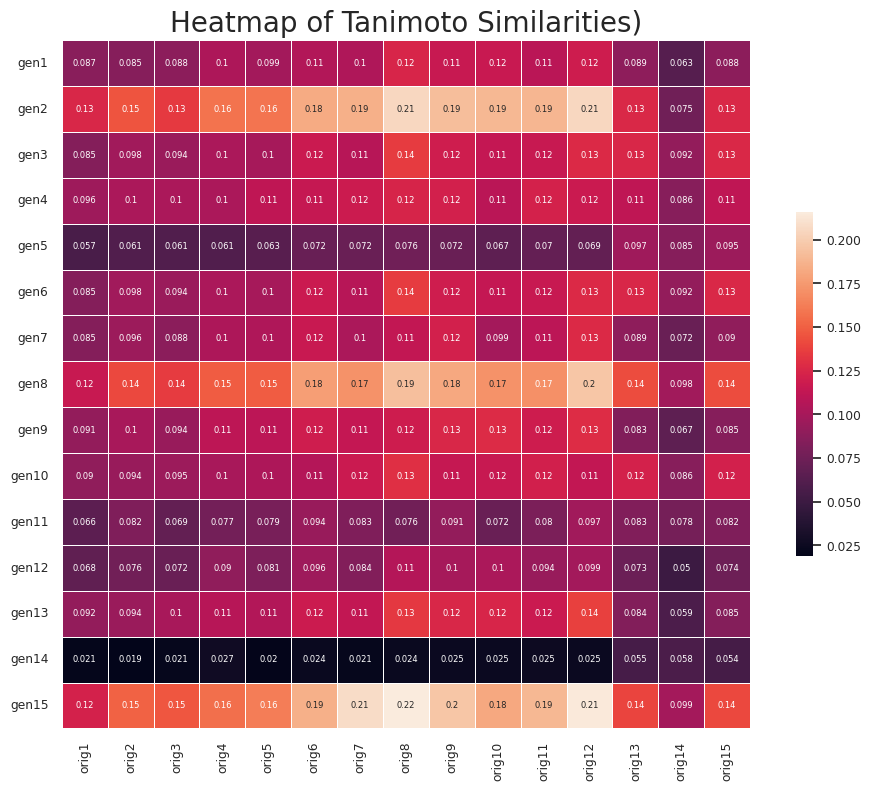

In [10]:
fp_generator = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7)

# Create fingerprints for all valid molecules
print("Generating fingerprints...")
generated_fps = [fp_generator.GetFingerprint(mol) for mol in generated_mols]
enumerated_fps = [fp_generator.GetFingerprint(mol) for mol in enumerated_mols]


# Calculate number of fingerprints
num_gen = len(generated_fps)
num_enum = len(enumerated_fps)
if num_gen == 0 or num_enum == 0:
    print("Error: No valid molecules found in one or both input sets after parsing. Cannot calculate similarities.")
    sys.exit()

print(f"Number of generated fingerprints: {num_gen}")
print(f"Number of enumerated fingerprints: {num_enum}")

# Calculate similarity matrix
print("Calculating similarity matrix...")
similarities = np.zeros((num_gen, num_enum))

for i in range(num_gen):
    similarities[i,:] = DataStructs.BulkTanimotoSimilarity(generated_fps[i], enumerated_fps)

def normal_heatmap(sim_matrix):
    try:
        np.savetxt(f"similarities.txt", sim_matrix)
    except Exception as e:
        pass

    plt.figure(figsize=(10, 8))
    sns.set(font_scale=0.8)

    plot = sns.heatmap(sim_matrix,
                       annot=True,
                       annot_kws={"fontsize": 6},
                       square=True,
                       xticklabels=[f'orig{i+1}' for i in range(sim_matrix.shape[1])],
                       yticklabels=[f'gen{i+1}' for i in range(sim_matrix.shape[0])],
                       linewidths=.7,
                       cbar_kws={"shrink": .5})

    plt.title(f'Heatmap of Tanimoto Similarities)', fontsize=20)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    try:
        plt.savefig(f"tanimoto_heatmap_{output_suffix}_0_1_scale.png")
        plt.show()
    except Exception as e:
        pass

# --- Statistics and Top Pairs ---
print(f"\nSimilarity Statistics ({fp_generator.__class__.__name__}):") # Indicate FP type
print(f"Average similarity: {np.mean(similarities):.3f}")
print(f"Maximum similarity: {np.max(similarities):.3f}")
print(f"Minimum similarity: {np.min(similarities):.3f}")

# Find most similar pairs
n_top = 5
# Ensure matrix is not empty before proceeding
if similarities.size > 0:
    # Handle potential case where fewer than n_top elements exist
    num_elements = similarities.size
    k = min(n_top, num_elements)
    if k > 0:
        flat_indices = np.argsort(similarities.flatten())[-k:] # Get top k indices
        row_indices, col_indices = np.unravel_index(flat_indices, similarities.shape)

        print(f"\nTop {k} most similar pairs:")
        # Iterate in descending order of similarity
        for i in range(k - 1, -1, -1):
            r = row_indices[i]
            c = col_indices[i]
            print(f"  Generated {r+1} vs Original {c+1}: {similarities[r,c]:.3f}")
    else:
        print("\nNo similarity values to find top pairs from.")
else:
    print("\nSimilarity matrix is empty.")


# Generate heatmap (passing the fingerprint name for titles/filenames)
if similarities.size > 0:
    normal_heatmap(similarities)